# PA4: Hugging Face Transformers - Text Summarization on SAMSum

 In this assignment, we will compare several pre-trained models from the Hugging Face
 model hub on text summarization and then fine-tune one of them on the SAMSum Dataset.

## Data  Loading and Exploratory Analysis


In [1]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from datasets import load_dataset
import evaluate
import torch
import accelerate

In [2]:
from huggingface_hub import login
login(token="")

In [3]:
from datasets import load_dataset

dataset = load_dataset("knkarthick/samsum")
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

train_data[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [4]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE:
Sebastian: It's been already a year since we moved here.
Sebastian: This is totally the best time of my life.
Kevin: Really? 
Sebastian: Yeah! Totally maaan.
Sebastian: During this 1 year I learned more than ever. 
Sebastian: I learned how to be resourceful, I'm learning responsibility, and I literally have the power to make my dreams come true.
Kevin: It's great to hear that.
Kevin: It's great that you are satisfied with your decisions.
Kevin: And above all it's great to see that you have someone you love by your side :)
Sebastian: Exactly!
Sebastian: That's another part of my life that is going great.
Kevin: I wish I had such a person by my side.
Sebastian: Don't worry about it.
Sebastian: I have a feeling this day will come shortly.
Kevin: Haha. I don' think s

In [5]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.6.0+cu124
12.4
True


In [6]:
print(f"Train size: {len(dataset['train'])}")
print(f"Validation size: {len(dataset['validation'])}")
print(f"Test size: {len(dataset['test'])}")

Train size: 14732
Validation size: 818
Test size: 819


In [7]:
missing = [i for i, ex in enumerate(dataset['train']) if not ex['dialogue'] or not ex['summary']]
print(f"Missing or empty samples in train: {len(missing)}")

Missing or empty samples in train: 1


Dialogue - Avg: 93.79, Min: 7, Max: 803
Summary  - Avg: 20.32, Min: 1, Max: 64


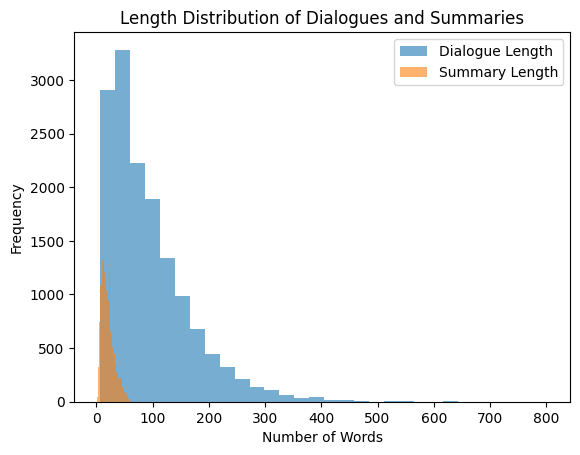

In [8]:
import matplotlib.pyplot as plt

dialogue_lengths = [
    len(sample['dialogue'].split())
    for sample in train_data
    if sample['dialogue'] is not None
]

summary_lengths = [
    len(sample['summary'].split())
    for sample in train_data
    if sample['summary'] is not None
]

print(f"Dialogue - Avg: {sum(dialogue_lengths)/len(dialogue_lengths):.2f}, Min: {min(dialogue_lengths)}, Max: {max(dialogue_lengths)}")
print(f"Summary  - Avg: {sum(summary_lengths)/len(summary_lengths):.2f}, Min: {min(summary_lengths)}, Max: {max(summary_lengths)}")


plt.hist(dialogue_lengths, bins=30, alpha=0.6, label='Dialogue Length')
plt.hist(summary_lengths, bins=30, alpha=0.6, label='Summary Length')
plt.legend()
plt.title("Length Distribution of Dialogues and Summaries")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

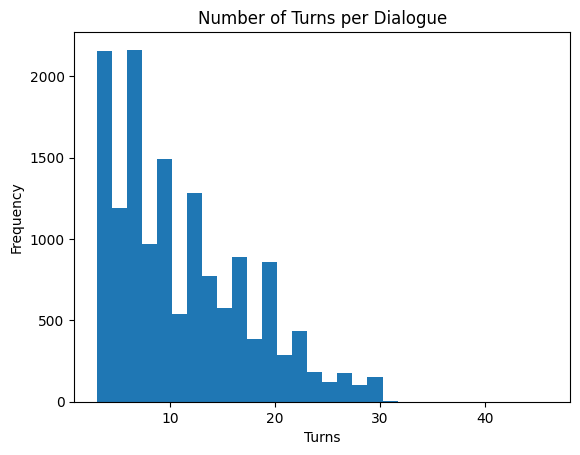

In [9]:
num_turns = [dialogue.count('\n') + 1 for dialogue in dataset['train']['dialogue'] if dialogue]
plt.hist(num_turns, bins=30)
plt.title("Number of Turns per Dialogue")
plt.xlabel("Turns")
plt.ylabel("Frequency")
plt.show()

In [10]:
from collections import Counter
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

all_tokens = []
for ex in dataset['train']:
    if ex['dialogue']:
        all_tokens.extend(nltk.word_tokenize(ex['dialogue'].lower()))

vocab_size = len(set(all_tokens))
print(f"Unique words in dialogues: {vocab_size}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Unique words in dialogues: 32748


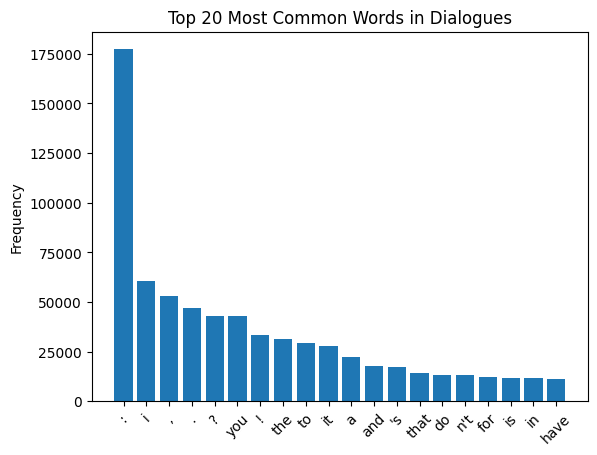

In [11]:
all_words = []
for ex in train_data:
    if ex['dialogue']:
        all_words.extend(nltk.word_tokenize(ex['dialogue'].lower()))
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

# Plot
words, freqs = zip(*most_common_words)
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words in Dialogues")
plt.ylabel("Frequency")
plt.show()

## Initial Inference for Summarization

In [12]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = {
    "DistilBART": "sshleifer/distilbart-cnn-12-6",
    "T5-Base": "t5-base",
    "PEGASUS-XSum": "google/pegasus-xsum",
    "FLAN-T5-Base": "google/flan-t5-base",
    "BART": "facebook/bart-large-cnn"
}

tokenizers = {}
models = {}

for name, model_id in model_names.items():
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to(device)
    tokenizers[name] = tokenizer
    models[name] = model

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import torch
print(torch.__version__)

2.6.0+cu124


In [14]:
def generate_summary(model_name, text, max_length=60, min_length=20):
    tokenizer = tokenizers[model_name]
    model = models[model_name]

    if "t5" in model_name.lower():
        text = "summarize: " + text

    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    ).to(device)

    output_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        min_length=min_length,
        do_sample=False
    )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [15]:
import random
random.seed(42)
example_indices = random.sample(range(len(dataset['test'])), 3)
dash_line = '-' * 120

for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    reference = dataset['test'][index]['summary']

    print(dash_line)
    print(f' Example {i + 1}')
    print(dash_line)
    print(f' INPUT DIALOGUE:\n{dialogue}')
    print(dash_line)
    print(f' HUMAN SUMMARY:\n{reference}')

    for model_name in models:
        tokenizer = tokenizers[model_name]
        model = models[model_name]

        input_text = "summarize: " + dialogue if "t5" in model_name.lower() else dialogue
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

        try:
            output_ids = model.generate(inputs["input_ids"], max_new_tokens=60, do_sample=False)
            generated_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        except Exception as e:
            generated_summary = f"[Error generating summary: {e}]"

        print(dash_line)
        print(f' {model_name.upper()} SUMMARY:\n{generated_summary}')
    print('\n')

------------------------------------------------------------------------------------------------------------------------
 Example 1
------------------------------------------------------------------------------------------------------------------------
 INPUT DIALOGUE:
Richie: Pogba
Clay: Pogboom
Richie: what a s strike yoh!
Clay: was off the seat the moment he chopped the ball back to his right foot
Richie: me too dude
Clay: hope his form lasts
Richie: This season he's more mature
Clay: Yeah, Jose has his trust in him
Richie: everyone does
Clay: yeah, he really deserved to score after his first 60 minutes
Richie: reward
Clay: yeah man
Richie: cool then 
Clay: cool
------------------------------------------------------------------------------------------------------------------------
 HUMAN SUMMARY:
Richie and Clay saw a very good football game, with one football player chopping the ball back to his foot, which was particularly exciting. Jose has trust in that player. 
----------------

### Analysis

#### Coherence and Fluency

- **DistilBART**, **BART**, and **FLAN-T5-Base** consistently produced **grammatically coherent** and **readable** summaries.
- **T5-Base** was **less consistent**; some outputs were incomplete or hallucinated unrelated content.
- **PEGASUS-XSum** occasionally generated summaries that were **too short**, **off-topic**, or missed the conversational structure entirely.

---

#### Coverage of Key Information

- **FLAN-T5-Base** and **DistilBART** were the most successful at **capturing the main point** of the conversation concisely.
- **BART** produced fluent summaries, though sometimes added extra context that wasn't strictly in the original dialogue.
- **T5-Base** often missed important cues and context, possibly due to lack of fine-tuning on dialog-specific datasets.
- **PEGASUS-XSum**, while fast it showed limitations in handling **multi-turn, informal dialogues**, often extracting only surface-level content or misinterpreting speaker roles.

In [16]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def lead_3_baseline(dialogue):
    """Return the first 3 sentences of the dialogue."""
    sentences = sent_tokenize(dialogue)
    return " ".join(sentences[:3])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
import evaluate
rouge = evaluate.load("rouge")


references = []
results = {"Lead-3": []}

for idx in example_indices:
    dialogue = dataset["test"][idx]["dialogue"]
    summary = dataset["test"][idx]["summary"]

    references.append(summary)
    results["Lead-3"].append(lead_3_baseline(dialogue))

#  Running all models on the same dialogues
for model_name in models:
    tokenizer = tokenizers[model_name]
    model = models[model_name]
    preds = []

    for idx in example_indices:
        dialogue = dataset["test"][idx]["dialogue"]
        input_text = "summarize: " + dialogue if "t5" in model_name.lower() else dialogue

        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
        output_ids = model.generate(inputs["input_ids"], max_new_tokens=60, do_sample=False)
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        preds.append(summary)

    results[model_name] = preds

In [18]:
for name, preds in results.items():
    score = rouge.compute(predictions=preds, references=references)
    print(f"\n ROUGE Scores for {name}:")
    for k, v in score.items():
        print(f"{k}: {v:.4f}")


 ROUGE Scores for Lead-3:
rouge1: 0.1769
rouge2: 0.0421
rougeL: 0.1314
rougeLsum: 0.1381

 ROUGE Scores for DistilBART:
rouge1: 0.3068
rouge2: 0.1010
rougeL: 0.2598
rougeLsum: 0.2598

 ROUGE Scores for T5-Base:
rouge1: 0.1909
rouge2: 0.0476
rougeL: 0.1432
rougeLsum: 0.1432

 ROUGE Scores for PEGASUS-XSum:
rouge1: 0.1734
rouge2: 0.0000
rougeL: 0.1035
rougeLsum: 0.1035

 ROUGE Scores for FLAN-T5-Base:
rouge1: 0.3090
rouge2: 0.0476
rougeL: 0.2123
rougeLsum: 0.2123

 ROUGE Scores for BART:
rouge1: 0.3586
rouge2: 0.1038
rougeL: 0.2653
rougeLsum: 0.2653


## Fine-tuning BART-cnn on SAMSum Dataset

In [26]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
import numpy as np
import evaluate
import torch

# Load tokenizer and base model
model_checkpoint = "sshleifer/distilbart-cnn-12-6"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


In [27]:
# Apply LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# Load SAMSum dataset
dataset = load_dataset("knkarthick/samsum")

# Clean entries
def filter_none(example):
    return example["dialogue"] is not None and example["summary"] is not None and \
           len(example["dialogue"].strip()) > 0 and len(example["summary"].strip()) > 0

dataset = dataset.filter(filter_none)

# Preprocessing
def preprocess(batch):
    model_inputs = tokenizer(
        batch["dialogue"], padding="max_length", truncation=True, max_length=768
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["summary"], padding="max_length", truncation=True, max_length=128
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainable params: 786,432 || all params: 306,296,832 || trainable%: 0.2568


Filter:   0%|          | 0/14732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/818 [00:00<?, ? examples/s]

Filter:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [28]:
# Evaluation metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}


In [29]:
# TrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./lora-bart-checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    num_train_epochs=3,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    predict_with_generate=True,
    generation_max_length=128,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.366300,1.043102,0.369000,0.174200,0.275000,0.275100,61.685800
2,1.302600,1.018308,0.373100,0.179900,0.280100,0.280000,61.701700
3,1.265800,1.012603,0.375400,0.182600,0.282500,0.282300,62.088000


TrainOutput(global_step=5526, training_loss=1.7322195855940419, metrics={'train_runtime': 3137.6941, 'train_samples_per_second': 14.085, 'train_steps_per_second': 1.761, 'total_flos': 5.146530916545331e+16, 'train_loss': 1.7322195855940419, 'epoch': 3.0})

In [33]:
model.save_pretrained("./lora-bart-checkpoints")

## Evaluation and Analysis before and after fine-tuning

In [36]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import evaluate
import numpy as np


tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")


model_pretrained = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
model_finetuned = AutoModelForSeq2SeqLM.from_pretrained("./lora-bart-checkpoints")


rouge = evaluate.load("rouge")

# Function to generate summaries
def generate_summary(model, dialogue, max_length=128):
    inputs = tokenizer(dialogue, return_tensors="pt", truncation=True, max_length=768)
    summary_ids = model.generate(inputs["input_ids"], max_length=max_length, num_beams=4)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


test_set = dataset["test"]
example_dialogues = [test_set[i]["dialogue"] for i in example_indices]
reference_summaries = [test_set[i]["summary"] for i in example_indices]


preds_pretrained = [generate_summary(model_pretrained, d) for d in example_dialogues]
preds_finetuned  = [generate_summary(model_finetuned, d) for d in example_dialogues]

# qualitative comparison
for i, idx in enumerate(example_indices):
    print(f"\n--- Example {i+1} ---")
    print(f"Dialogue:\n{example_dialogues[i]}")
    print(f"\nHuman Summary:\n{reference_summaries[i]}")
    print(f"\nPretrained Summary:\n{preds_pretrained[i]}")
    print(f"Fine-tuned Summary:\n{preds_finetuned[i]}")

# Quantitative ROUGE comparison
rouge_pre = rouge.compute(predictions=preds_pretrained, references=reference_summaries, use_stemmer=True)
rouge_fine = rouge.compute(predictions=preds_finetuned, references=reference_summaries, use_stemmer=True)

def extract_avg_rouge(metrics):
    return {
        "rouge1": metrics["rouge1"],
        "rouge2": metrics["rouge2"],
        "rougeL": metrics["rougeL"],
        "rougeLsum": metrics["rougeLsum"],
    }

print("\nROUGE Scores:")
print("Pretrained:", extract_avg_rouge(rouge_pre))
print("Fine-tuned:", extract_avg_rouge(rouge_fine))


--- Example 1 ---
Dialogue:
Richie: Pogba
Clay: Pogboom
Richie: what a s strike yoh!
Clay: was off the seat the moment he chopped the ball back to his right foot
Richie: me too dude
Clay: hope his form lasts
Richie: This season he's more mature
Clay: Yeah, Jose has his trust in him
Richie: everyone does
Clay: yeah, he really deserved to score after his first 60 minutes
Richie: reward
Clay: yeah man
Richie: cool then 
Clay: cool

Human Summary:
Richie and Clay saw a very good football game, with one football player chopping the ball back to his foot, which was particularly exciting. Jose has trust in that player. 

Pretrained Summary:
 Richie: Pogba's strike was off the seat the moment he chopped the ball back to his right foot . Pogba has been more mature this season than ever before, says Richie . He said: "Yeah, Jose has his trust in him. He really deserved to score after his first 60 minutes"
Fine-tuned Summary:
Pba scored after his first 60 minutes. Jose has his trust in him. Pogb